##Compact Convolutional Transformer

#####Code Reference: https://keras.io/examples/vision/cct/

#####Importing libraries

In [ ]:
#!pip install tensorflow-gpu==2.8.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math, gc, warnings, scipy, random, os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
warnings.filterwarnings('ignore')

EPOCHS = 200
BATCH_SIZE = 32
IMG_SIZE = (208, 176)
SEED = 100
CLASSES = 4
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98
#with tf.device("/gpu:0"):

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
2.8.0


#####Reading data as a tensorflow dataset

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    }),
    total_num_examples=13174,
    splits={
        'test': 1279,
        'train': 5329,
        'train2': 6566,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



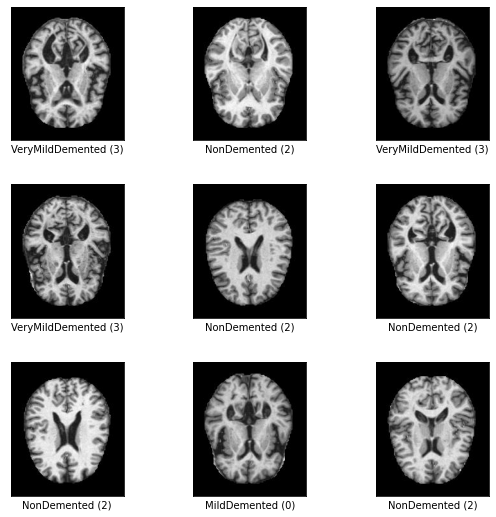

In [3]:
builder = tfds.folder_dataset.ImageFolder("drive/MyDrive/CV/Alzheimer_Dataset/")
print(builder.info)  
ds_info = builder.info
ds_train = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds_train, builder.info)

In [4]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

#####

In [5]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # print(image)
    image = tf.cast(image, tf.float32) / 255.
    
    return 2*(image - 0.5), tf.one_hot(label, depth = 4)
    
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa


num_classes = 4
#num_classes = 10
input_shape = (208, 176, 3)
#input_shape = (32, 32, 3)
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train/ModerateDemented/moderateDem0.jpg")
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 130
image_size = 128


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)
        self.num_conv_layers=num_conv_layers
        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(self.num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb
    def get_config(self):

        config = super().get_config().copy()
        config.update({
        'kernel_size':3,
        'stride':1,
        'padding':1,
        'pooling_kernel_size':3,
        'pooling_stride':2,
        'num_conv_layers':self.num_conv_layers,
        'num_output_channels':[64, 128],
        'positional_emb':self.positional_emb
        })
        return config
    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

(1, 128, 128, 3)


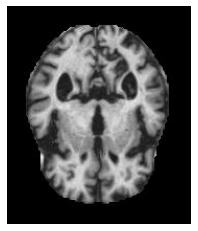

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train/ModerateDemented/moderateDem0.jpg")
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = CCTTokenizer()(resized_image)
print(resized_image.shape)

In [9]:
for i in ds_train.take(1).as_numpy_iterator():
    print(i[1][0])
    print(i[0].shape, i[1].shape)
    break

[1. 0. 0. 0.]
(32, 208, 176, 3) (32, 4)


In [10]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

    def get_config(self):

        config = super().get_config().copy()
        config.update({
        'drop_prob':self.drop_prob
        })
        return config

In [11]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    
    inputs = layers.Input(input_shape)
    
    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model

In [ ]:
cct_model=create_cct_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  7          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer_1 (CCTTokenizer)  (None, 1024, 128)   75456       ['data_augmentation[0][0]']      
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 1024, 128)   0           ['cct_tokenizer_1[0][0]']    

In [ ]:
#with tf.device("/gpu:0"):
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

cct_model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
    ],
)

history = cct_model.fit(
    ds_train,
    batch_size=batch_size,
    epochs=130,
    verbose=2,
    validation_data=ds_test
)

_, accuracy, top_2_accuracy = cct_model.evaluate(ds_test)#x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 2 accuracy: {round(top_2_accuracy * 100, 2)}%")
cct_model.save_weights("/content/drive/MyDrive/Alzheimer_Dataset/cct_model.h5")

Epoch 1/130
167/167 - 51s - loss: 1.1585 - accuracy: 0.4911 - top-2-accuracy: 0.8163 - val_loss: 1.0796 - val_accuracy: 0.5223 - val_top-2-accuracy: 0.8530 - 51s/epoch - 303ms/step
Epoch 2/130
167/167 - 41s - loss: 1.1259 - accuracy: 0.5040 - top-2-accuracy: 0.8174 - val_loss: 1.0731 - val_accuracy: 0.5496 - val_top-2-accuracy: 0.8616 - 41s/epoch - 248ms/step
Epoch 3/130
167/167 - 41s - loss: 1.1063 - accuracy: 0.5224 - top-2-accuracy: 0.8195 - val_loss: 1.0660 - val_accuracy: 0.5801 - val_top-2-accuracy: 0.8632 - 41s/epoch - 245ms/step
Epoch 4/130
167/167 - 41s - loss: 1.0944 - accuracy: 0.5279 - top-2-accuracy: 0.8230 - val_loss: 1.0671 - val_accuracy: 0.5661 - val_top-2-accuracy: 0.8694 - 41s/epoch - 247ms/step
Epoch 5/130
167/167 - 41s - loss: 1.0880 - accuracy: 0.5258 - top-2-accuracy: 0.8296 - val_loss: 1.0731 - val_accuracy: 0.5582 - val_top-2-accuracy: 0.8561 - 41s/epoch - 246ms/step
Epoch 6/130
167/167 - 41s - loss: 1.0825 - accuracy: 0.5311 - top-2-accuracy: 0.8294 - val_loss

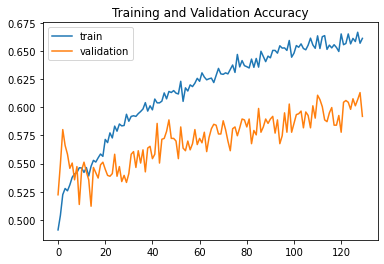

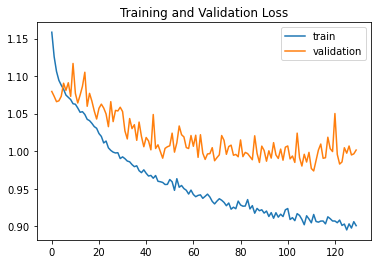

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='validation') 
pyplot.title("Training and Validation Accuracy")
pyplot.legend() 
pyplot.show()

pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.title("Training and Validation Loss")
pyplot.legend() 
pyplot.show()


In [17]:
cct_model = create_cct_model()
cct_model.load_weights("/content/drive/MyDrive/CV/Alzheimer_Dataset/cct_model.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  7          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 1024, 128)    75456       ['data_augmentation[2][0]']      
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 1024, 128)   0           ['cct_tokenizer[0][0]']      

In [18]:
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train2/ModerateDemented/moderateDem5.jpg")
# image = cv2.imread("/content/drive/MyDrive/CV/Alzheimer_Dataset/train2/ModerateDemented/moderateDem5.jpg")
outputs = [
        l.output for l in cct_model.layers if l.name in ['layer_normalization_2', 'layer_normalization_4']
    ]
weights = np.array(tf.keras.models.Model(inputs=cct_model.inputs, outputs=outputs).predict(np.expand_dims(image, axis=0)))
num_layers = weights.shape[0]
num_heads = weights.shape[-1]



In [19]:
grid_size = int(np.sqrt(cct_model.get_layer("layer_normalization_2").output_shape[-2] - 1))

reshaped = weights.reshape(
        (num_layers, num_heads, grid_size +1, grid_size+1)
    )

reshaped = reshaped.mean(axis=1)
reshaped = reshaped + np.eye(*reshaped.shape[1:])
reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

v = reshaped[-1]
for n in range(1, len(reshaped)):
    v = np.matmul(v, reshaped[-1 - n].T)

# # Attention from the output token to the input space.
mask = v#[0, 1:].reshape(grid_size, grid_size)
mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
    ..., np.newaxis
]
masked_img = (mask * image).astype("uint8")

Text(0.5, 1.0, 'Attention Image')

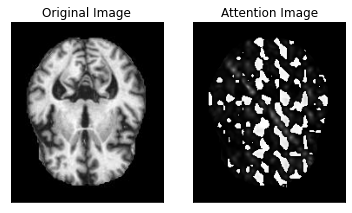

In [20]:
ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(image)
plt.title("Original Image")

ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(masked_img)
plt.title("Attention Image")